# Full Binary Model

## Import the Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, initializers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers, metrics

In [2]:
# upload csv files
# setting the dtype=str is to prevent an error that occurs later on if I don't

traindf=pd.read_csv("./diabetic-retinopathy-detection/Data/trainLabels.csv",dtype=str)
testdf=pd.read_csv("./diabetic-retinopathy-detection/Data/sampleSubmission.csv",dtype=str)

In [3]:
traindf.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Clean the Data

In [4]:
# creating a function that adds ".jpeg" to the image names
def append_ext(fn):
    return fn+".jpeg"

traindf["image"]=traindf["image"].apply(append_ext)
testdf["image"]=testdf["image"].apply(append_ext)

In [5]:
# checking work
traindf.head()

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


### Change Target to Binary

In [6]:
traindf.level.replace({"2":"1", "3":"1", "4":"1"}, inplace=True)
traindf.level.value_counts(normalize=True)

0    0.734783
1    0.265217
Name: level, dtype: float64

### Load Images

In [7]:
# define variables
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"

In [8]:
datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range=90,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=0.1,
                           horizontal_flip=True,
                           vertical_flip=True,
                           brightness_range=[0.75,1.25],
                           validation_split=0.2)

In [9]:
# training generator (subset=training)
train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="./diabetic-retinopathy-detection/Data/train/",
x_col="image",
y_col="level",
subset="training",
batch_size=batches,
seed=42,
shuffle=True,
class_mode="binary",
target_size=size)


# validation generator (subset=validation)
valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="./diabetic-retinopathy-detection/Data/train/",
x_col="image",
y_col="level",
subset="validation",
batch_size=batches,
seed=42,
shuffle=True,
class_mode="binary",
target_size=size)

# test generator
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="./diabetic-retinopathy-detection/Data/test/",
x_col="image",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=size)

Found 28101 validated image filenames belonging to 2 classes.
Found 7025 validated image filenames belonging to 2 classes.
Found 53576 validated image filenames.


## Build Model

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation=activation, padding = 'same', input_shape=shape))
model.add(Conv2D(32, (3, 3), activation=activation, padding = 'same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation=activation))
model.add(Conv2D(64, (3, 3), activation=activation))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation=activation))
model.add(Conv2D(64, (3, 3), activation=activation))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation = activation, kernel_initializer=initializers.HeNormal()))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [12]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=1e-4,
                                     verbose=1,
                                     mode='min',
                                     patience=5)

In [14]:
results = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=25,
                    callbacks=early_stop)

Epoch 1/25
878/878 [==============================] - 2452s 3s/step - loss: 0.5797 - accuracy: 0.7359 - val_loss: 0.5817 - val_accuracy: 0.7305
Epoch 2/25
878/878 [==============================] - 3376s 4s/step - loss: 0.5777 - accuracy: 0.7358 - val_loss: 0.5817 - val_accuracy: 0.7305
Epoch 3/25
878/878 [==============================] - 2535s 3s/step - loss: 0.5772 - accuracy: 0.7360 - val_loss: 0.5812 - val_accuracy: 0.7305
Epoch 4/25
878/878 [==============================] - 2540s 3s/step - loss: 0.5762 - accuracy: 0.7358 - val_loss: 0.5826 - val_accuracy: 0.7307
Epoch 5/25
878/878 [==============================] - 2500s 3s/step - loss: 0.5766 - accuracy: 0.7357 - val_loss: 0.5794 - val_accuracy: 0.7305
Epoch 6/25
878/878 [==============================] - 2435s 3s/step - loss: 0.5768 - accuracy: 0.7359 - val_loss: 0.5828 - val_accuracy: 0.7305
Epoch 7/25
878/878 [==============================] - 2584s 3s/step - loss: 0.5773 - accuracy: 0.7359 - val_loss: 0.5840 - val_accuracy:

## Results

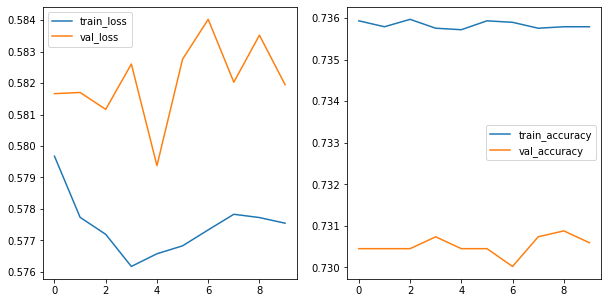

In [15]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [16]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

220/220 [==============================] - 481s 2s/step - loss: 0.5818 - accuracy: 0.7305
Test loss: 0.581807017326355
Test accuracy: 0.73053377866745


In [17]:
# This gives probabilities which is needed to get the y predictions
pred = model.predict(valid_generator, steps = valid_generator.n//valid_generator.batch_size)

# The y predictions which is needed for the confusion matrix
y_pred = pred.argmax(axis=-1)

219/219 [==============================] - 479s 2s/step


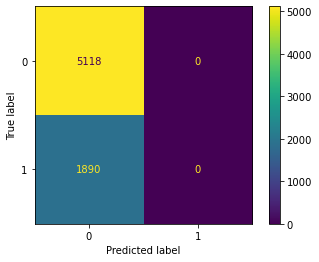

In [18]:
ConfusionMatrixDisplay.from_predictions(valid_generator.classes[:len(y_pred)], y_pred)

## Save Model

In [20]:
# save model
tf.keras.models.save_model(model, "full_binary_model.hdf5")